<a href="https://colab.research.google.com/github/agarr3/vajra-new-2/blob/main/AE_HYBRID_COMBINED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt
import torch
# Neural networks can be constructed using the torch.nn package.
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms

import IPython.display as ipd

import random

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#settings
batch_size = 64
validation_split = .3
shuffle_dataset = True
random_seed= 42
reduction_loss = "mean"
if reduction_loss == "mean":
  criterion = nn.MSELoss(reduction="mean")
elif reduction_loss == "sum":
  criterion = nn.MSELoss(reduction="sum")
n_epochs = 30
print_every = 1

BASE_PATH = "/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/"

input_bins = 48
seq_len=200
AE_encoded_dim = 64

class_level_loss_mode = "test"

print(device)

cuda:0


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
DATA_BASE_PATH = "/content/gdrive/My Drive/vajra/songs-vajra-data/MEL/48Bins"
DATA_SONG_DIR = "Chunked"
DATA_IMG_DIR = "Chunked"

files = []
western_files = []
exclusion = ["098567.npy","098569.npy", '098565.npy']
for r,d, fileList in os.walk(os.path.join(DATA_BASE_PATH, DATA_SONG_DIR, "Western_numpy")):
  for file in fileList:
    if(file not in exclusion):
      western_files.append([file,file, "Western_numpy"])
    else:
      print(file)

# random.seed(1234)
# western_files = random.sample(western_files, 2008)

indian_files = []
for r,d, fileList in os.walk(os.path.join(DATA_BASE_PATH, DATA_SONG_DIR, "Indian_numpy")):
  for file in fileList:
    if(True):
      indian_files.append([file,file, "Indian_numpy"])
    else:
      print(file)

files = indian_files + western_files
dataDF = pd.DataFrame(files, columns=['Images','songs','labels'])
dataDF.head()

,Images,songs,labels
0,indianNizhalinaiNijamum_mel_0.npy,indianNizhalinaiNijamum_mel_0.npy,Indian_numpy
1,indianNizhalinaiNijamum_mel_1.npy,indianNizhalinaiNijamum_mel_1.npy,Indian_numpy
2,indianOhOh_mel_0.npy,indianOhOh_mel_0.npy,Indian_numpy
3,indianOhOh_mel_1.npy,indianOhOh_mel_1.npy,Indian_numpy
4,indianOnnavittaYaarumYenakilla_mel_0.npy,indianOnnavittaYaarumYenakilla_mel_0.npy,Indian_numpy


In [6]:
dataDF.groupby("labels").count()

,Images,songs
labels,,
Indian_numpy,4016,4016
Western_numpy,2000,2000


/content/gdrive/My Drive/vajra/songs-vajra-data/MEL/48Bins/Chunked/Indian_numpy/indianNenjilIdanenjil_mel_1.npy
80.0


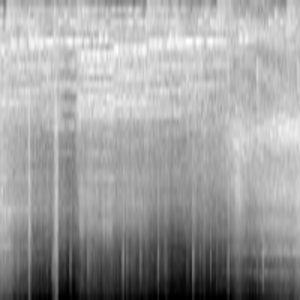

In [7]:
test_idx = random. randint(0,1000)
test_img_path = os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, dataDF.loc[test_idx, 'labels'], dataDF.loc[test_idx, 'Images'])
print(test_img_path)

numpy_arr = np.load(test_img_path)

array = numpy_arr*-1
print(array.max())
array *= (255.0/array.max())
array = 255 - array

test_image = Image.fromarray(array)
test_image = test_image.convert('L')
test_image = test_image.resize((300,300))
test_image



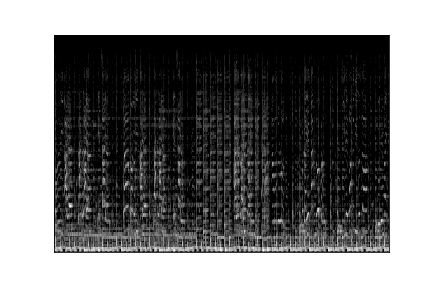

In [8]:
test_img_path = '/content/gdrive/My Drive/Kaggle/GTZAN/Data/images_original/reggae/reggae00016.png'
test_image = Image.open(test_img_path)
test_image = test_image.convert('RGB').convert('L')
test_image

In [9]:
lb = LabelEncoder()
dataDF['encoded_labels'] = lb.fit_transform(dataDF['labels'])
dataDF.head()

,Images,songs,labels,encoded_labels
0,indianNizhalinaiNijamum_mel_0.npy,indianNizhalinaiNijamum_mel_0.npy,Indian_numpy,0
1,indianNizhalinaiNijamum_mel_1.npy,indianNizhalinaiNijamum_mel_1.npy,Indian_numpy,0
2,indianOhOh_mel_0.npy,indianOhOh_mel_0.npy,Indian_numpy,0
3,indianOhOh_mel_1.npy,indianOhOh_mel_1.npy,Indian_numpy,0
4,indianOnnavittaYaarumYenakilla_mel_0.npy,indianOnnavittaYaarumYenakilla_mel_0.npy,Indian_numpy,0


In [10]:
classes = ('Indian_numpy', 'Western_numpy')
dataDF.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_numpy,0,4016,4016
Western_numpy,1,2000,2000


In [11]:
from sklearn.model_selection import train_test_split

dataDF = dataDF.sample(frac=1)
df_train, df_test = train_test_split(dataDF, test_size=validation_split, stratify=dataDF[["labels"]], random_state=9)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)


if class_level_loss_mode == "test":
  western_dataDF = df_test[df_test['labels'] == "Western_numpy"]
  western_dataDF = western_dataDF.reset_index(drop=True)
  indian_dataDF = df_test[df_test['labels'] == "Indian_numpy"]
  indian_dataDF = indian_dataDF.reset_index(drop=True)

In [12]:
df_train.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_numpy,0,2811,2811
Western_numpy,1,1400,1400


In [13]:
df_test.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_numpy,0,1205,1205
Western_numpy,1,600,600


In [14]:
indian_dataDF.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_numpy,0,1205,1205


In [15]:
transform_normal = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform = transforms.Compose(
    [transforms.ToTensor()])

In [16]:
class MEL_Dataset(Dataset):
    def __init__(self, img_data,img_path,transform=None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_name = os.path.join(self.img_path,self.img_data.loc[index, 'labels'],
                                self.img_data.loc[index, 'Images'])
        image = np.load(img_name)
        data = torch.tensor(image[:,:seq_len], dtype=torch.float)
        data = data.permute(1, 0)
        label = torch.tensor(self.img_data.loc[index, 'encoded_labels'])
        fileName = self.img_data.loc[index, 'Images']
        return data, label, fileName



In [17]:
train_dataset = MEL_Dataset(df_train,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR),transform)
test_dataset = MEL_Dataset(df_test,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR),transform)

In [18]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [19]:
indian_dataset = MEL_Dataset(indian_dataDF,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR),transform)
western_dataset = MEL_Dataset(western_dataDF,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR),transform)

indian_loader = torch.utils.data.DataLoader(indian_dataset, batch_size=batch_size)
western_loader = torch.utils.data.DataLoader(western_dataset, batch_size=batch_size)


In [20]:
def mel_display(S_DB):
    S_DB = S_DB.numpy()
    array = S_DB*-1
    array *= (255.0/array.max())
    #array = 255 - array
    array = np.transpose(array, (2, 1, 0))
    return array.squeeze()

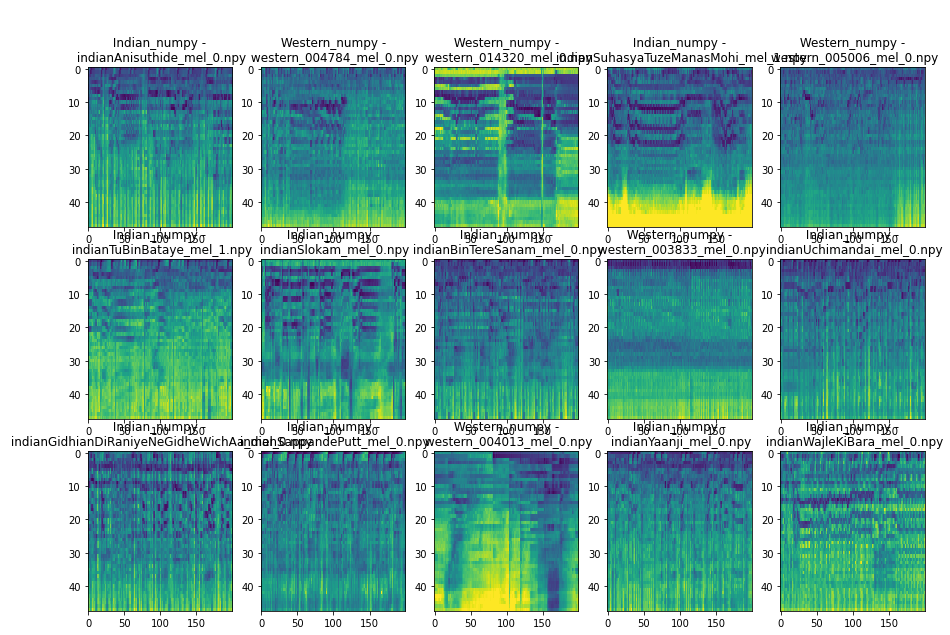

In [21]:
# get some random training images
dataiter = iter(trainloader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label, fileName = images[i], labels[i], fileNames[i]
        ax.imshow(mel_display(image.unsqueeze(dim=0)), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"\n \n {arthopod_types[label.item()]} - \n {fileName}") # add label

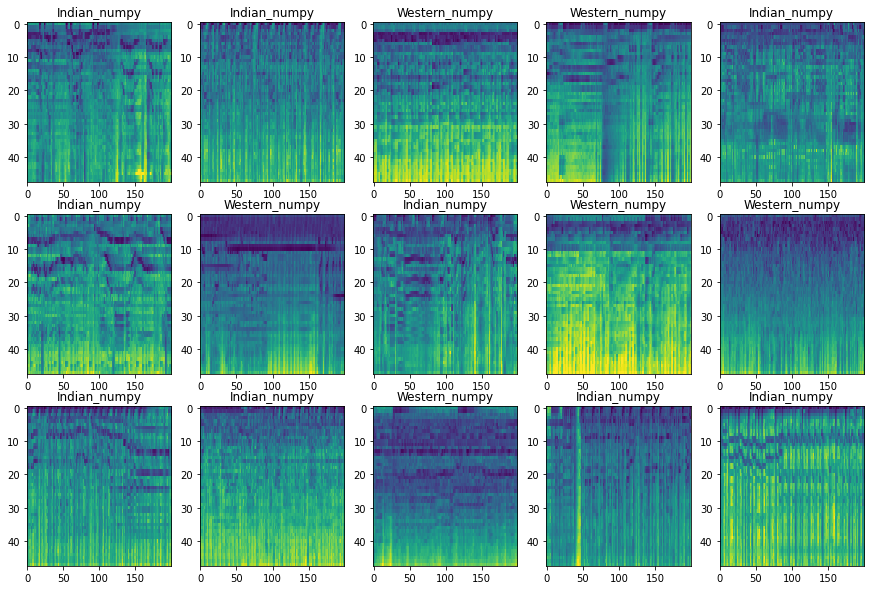

In [22]:
# get some random training images
dataiter = iter(testloader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(mel_display(image.unsqueeze(dim=0)), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

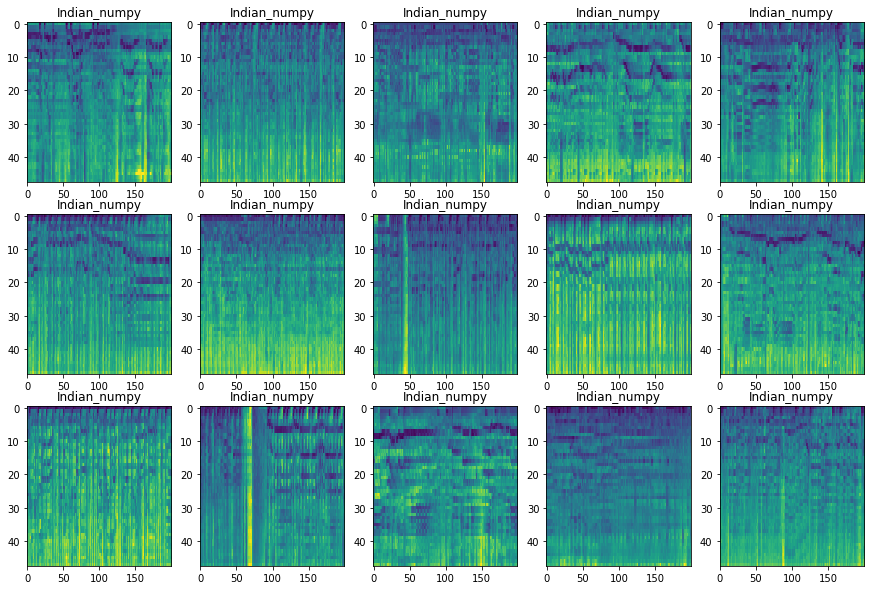

In [23]:
# get some random training images
dataiter = iter(indian_loader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(mel_display(image.unsqueeze(dim=0)), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

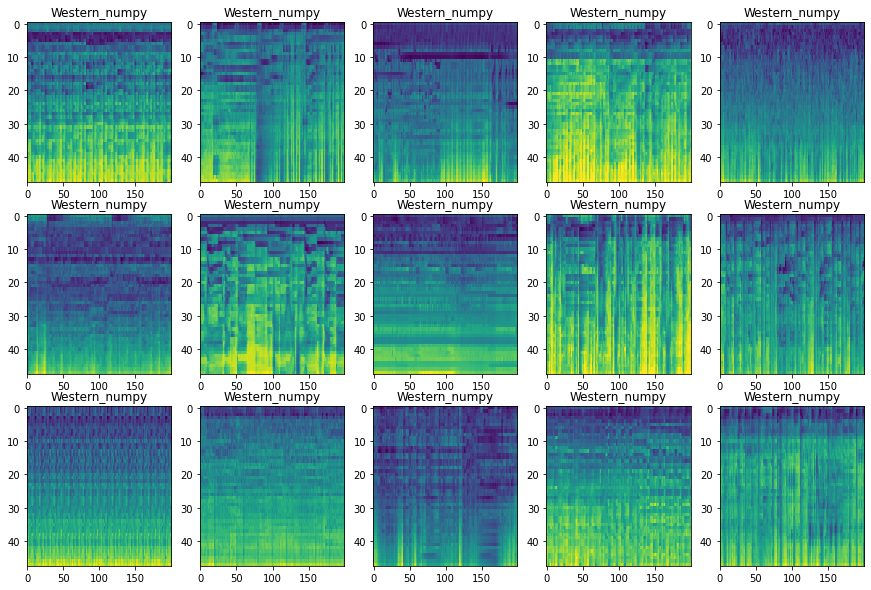

In [24]:
# get some random training images
dataiter = iter(western_loader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(mel_display(image.unsqueeze(dim=0)), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

In [25]:
class Encoder(torch.nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64, kernel_size=[4,3,2], stride=[1,1,1]):
    super(Encoder, self).__init__()
    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim


    self.conv = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size[0],stride=stride[0], groups=seq_len)
    conv_op_dim = int(((n_features - kernel_size[0])/ stride[0]) + 1)

    self.conv_1 = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size[1],stride=stride[1], groups=seq_len)
    conv_op_dim1 = int(((conv_op_dim - kernel_size[1])/ stride[1]) + 1)

    self.conv_2 = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size[2],stride=stride[2], groups=seq_len)
    conv_op_dim2 = int(((conv_op_dim1 - kernel_size[2])/ stride[2]) + 1)

    self.rnn1 = nn.LSTM(
      input_size=conv_op_dim2,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
  def forward(self, x):
    x = self.conv(x)
    x = self.conv_1(x)
    x = self.conv_2(x)
    lstm_l1_op, (_, _) = self.rnn1(x)
    lstm_l2_op, (hidden_n, _) = self.rnn2(lstm_l1_op)
    return lstm_l2_op, lstm_l1_op

class Decoder(torch.nn.Module):
  def __init__(self, seq_len, embedding_dim=64, n_features=26):
    super(Decoder, self).__init__()
    self.seq_len, self.embedding_dim = seq_len, embedding_dim
    self.hidden_dim, self.n_features = 2 * embedding_dim, n_features
    self.rnn1 = nn.LSTM(
      input_size=embedding_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=embedding_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.output_layer = nn.Linear(self.hidden_dim * self.seq_len, n_features * self.seq_len)
  def forward(self, x):
    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.contiguous()
    x = x.view(x.shape[0], -1)
    x = self.output_layer(x)
    return x.reshape(x.shape[0],self.seq_len, self.n_features)

class RecurrentAutoencoder(torch.nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64, device='cpu'):
    super(RecurrentAutoencoder, self).__init__()
    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)
  def forward(self, x):
    x, l1_op = self.encoder(x)
    x = self.decoder(x)
    return x

net = RecurrentAutoencoder(seq_len, input_bins, AE_encoded_dim, device=device)
net.to(device)


RecurrentAutoencoder(
  (encoder): Encoder(
    (conv): Conv1d(200, 200, kernel_size=(4,), stride=(1,), groups=200)
    (conv_1): Conv1d(200, 200, kernel_size=(3,), stride=(1,), groups=200)
    (conv_2): Conv1d(200, 200, kernel_size=(2,), stride=(1,), groups=200)
    (rnn1): LSTM(42, 128, batch_first=True)
    (rnn2): LSTM(128, 64, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(64, 64, batch_first=True)
    (rnn2): LSTM(64, 128, batch_first=True)
    (output_layer): Linear(in_features=25600, out_features=9600, bias=True)
  )
)

In [26]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [27]:
import matplotlib.pyplot as plt
import numpy as np

def visualize(train_loss_graph, test_loss_graph):
  x = range(len(train_loss_graph))
      
  # plot lines
  plt.plot(x, train_loss_graph, label = "Training Loss")
  plt.plot(x, test_loss_graph, label = "Test Loss")
  
  plt.legend()
  plt.show()


def visualize_class_loss(in_loss_graph, we_loss_graph):
  x = range(len(in_loss_graph))
      
  # plot lines
  plt.plot(x, in_loss_graph, label = "Indian Loss")
  plt.plot(x, we_loss_graph, label = "Western Loss")
  
  plt.legend()
  plt.show()


[1,     1] loss: 1273.371
[1,     2] loss: 1306.473
[1,     3] loss: 1196.208
[1,     4] loss: 1042.069
[1,     5] loss: 946.244
[1,     6] loss: 792.728
[1,     7] loss: 571.856
[1,     8] loss: 357.676
[1,     9] loss: 146.239
[1,    10] loss: 517.947
[1,    11] loss: 305.000
[1,    12] loss: 120.644
[1,    13] loss: 116.852
[1,    14] loss: 159.130
[1,    15] loss: 182.186
[1,    16] loss: 240.368
[1,    17] loss: 214.692
[1,    18] loss: 186.340
[1,    19] loss: 137.803
[1,    20] loss: 120.130
[1,    21] loss: 125.576
[1,    22] loss: 102.287
[1,    23] loss: 126.537
[1,    24] loss: 148.571
[1,    25] loss: 137.014
[1,    26] loss: 140.025
[1,    27] loss: 117.925
[1,    28] loss: 107.580
[1,    29] loss: 94.961
[1,    30] loss: 92.399
[1,    31] loss: 95.153
[1,    32] loss: 120.100
[1,    33] loss: 113.111
[1,    34] loss: 109.664
[1,    35] loss: 100.907
[1,    36] loss: 103.592
[1,    37] loss: 104.596
[1,    38] loss: 94.937
[1,    39] loss: 87.837
[1,    40] loss: 97.322
[1

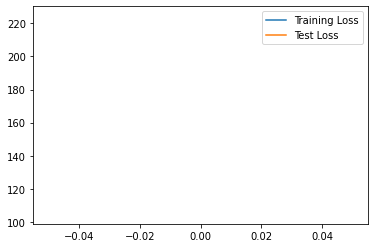

LOSS of the network on the test images: 1494 %
Mean of the network on the Indian images after epoch 0 is 83.04579755995009
LOSS of the network on the test images: 1444 %
Mean of the network on the Western images after epoch 0 is 160.48481920030383


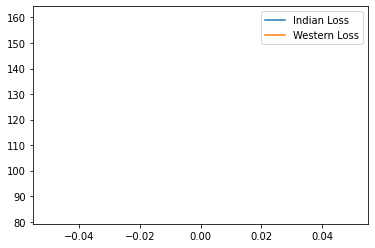

[2,     1] loss: 97.689
[2,     2] loss: 99.331
[2,     3] loss: 105.704
[2,     4] loss: 96.749
[2,     5] loss: 83.938
[2,     6] loss: 106.382
[2,     7] loss: 86.880
[2,     8] loss: 94.264
[2,     9] loss: 78.863
[2,    10] loss: 109.481
[2,    11] loss: 100.745
[2,    12] loss: 79.911
[2,    13] loss: 93.175
[2,    14] loss: 90.923
[2,    15] loss: 88.363
[2,    16] loss: 98.218
[2,    17] loss: 91.807
[2,    18] loss: 103.068
[2,    19] loss: 82.973
[2,    20] loss: 91.832
[2,    21] loss: 98.127
[2,    22] loss: 86.609
[2,    23] loss: 93.894
[2,    24] loss: 95.270
[2,    25] loss: 79.844
[2,    26] loss: 90.776
[2,    27] loss: 88.897
[2,    28] loss: 89.731
[2,    29] loss: 81.617
[2,    30] loss: 84.936
[2,    31] loss: 83.379
[2,    32] loss: 97.373
[2,    33] loss: 94.120
[2,    34] loss: 86.179
[2,    35] loss: 80.708
[2,    36] loss: 83.543
[2,    37] loss: 85.667
[2,    38] loss: 82.615
[2,    39] loss: 75.126
[2,    40] loss: 81.996
[2,    41] loss: 78.405
[2,    42] 

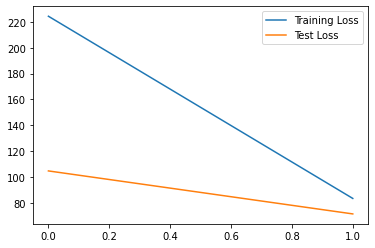

LOSS of the network on the test images: 1198 %
Mean of the network on the Indian images after epoch 1 is 66.60016038682726
LOSS of the network on the test images: 813 %
Mean of the network on the Western images after epoch 1 is 90.43173556857639


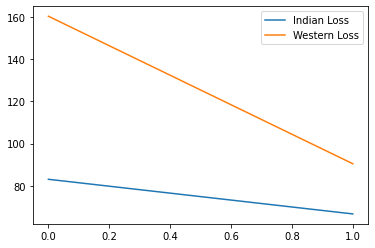

[3,     1] loss: 72.110
[3,     2] loss: 69.559
[3,     3] loss: 69.639
[3,     4] loss: 64.219
[3,     5] loss: 64.925
[3,     6] loss: 71.391
[3,     7] loss: 65.488
[3,     8] loss: 63.888
[3,     9] loss: 63.006
[3,    10] loss: 73.017
[3,    11] loss: 71.915
[3,    12] loss: 62.302
[3,    13] loss: 71.848
[3,    14] loss: 74.365
[3,    15] loss: 67.552
[3,    16] loss: 71.506
[3,    17] loss: 70.636
[3,    18] loss: 64.937
[3,    19] loss: 64.906
[3,    20] loss: 60.869
[3,    21] loss: 70.507
[3,    22] loss: 70.967
[3,    23] loss: 65.118
[3,    24] loss: 69.768
[3,    25] loss: 59.313
[3,    26] loss: 66.949
[3,    27] loss: 63.638
[3,    28] loss: 72.302
[3,    29] loss: 61.404
[3,    30] loss: 68.281
[3,    31] loss: 65.001
[3,    32] loss: 73.270
[3,    33] loss: 68.962
[3,    34] loss: 65.848
[3,    35] loss: 64.221
[3,    36] loss: 64.069
[3,    37] loss: 64.283
[3,    38] loss: 70.241
[3,    39] loss: 64.586
[3,    40] loss: 70.988
[3,    41] loss: 69.298
[3,    42] loss:

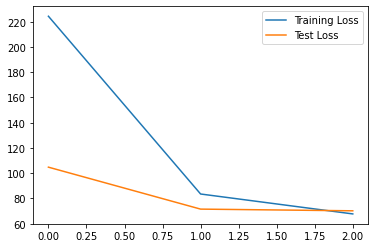

LOSS of the network on the test images: 1185 %
Mean of the network on the Indian images after epoch 2 is 65.87112469143338
LOSS of the network on the test images: 790 %
Mean of the network on the Western images after epoch 2 is 87.82663896348741


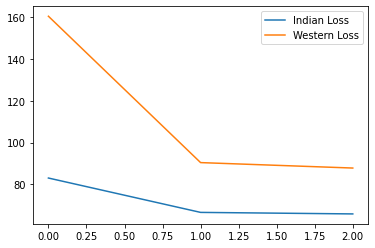

[4,     1] loss: 70.825
[4,     2] loss: 68.004
[4,     3] loss: 67.995
[4,     4] loss: 63.181
[4,     5] loss: 64.365
[4,     6] loss: 69.953
[4,     7] loss: 64.183
[4,     8] loss: 63.206
[4,     9] loss: 62.101
[4,    10] loss: 72.326
[4,    11] loss: 70.600
[4,    12] loss: 61.676
[4,    13] loss: 71.008
[4,    14] loss: 73.521
[4,    15] loss: 66.799
[4,    16] loss: 70.403
[4,    17] loss: 69.002
[4,    18] loss: 64.124
[4,    19] loss: 63.782
[4,    20] loss: 60.386
[4,    21] loss: 69.339
[4,    22] loss: 70.059
[4,    23] loss: 64.049
[4,    24] loss: 68.847
[4,    25] loss: 58.641
[4,    26] loss: 66.034
[4,    27] loss: 63.215
[4,    28] loss: 71.356
[4,    29] loss: 60.905
[4,    30] loss: 67.355
[4,    31] loss: 64.435
[4,    32] loss: 72.095
[4,    33] loss: 68.089
[4,    34] loss: 65.190
[4,    35] loss: 64.021
[4,    36] loss: 63.316
[4,    37] loss: 63.604
[4,    38] loss: 69.682
[4,    39] loss: 64.049
[4,    40] loss: 70.439
[4,    41] loss: 68.541
[4,    42] loss:

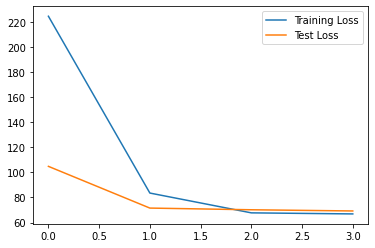

LOSS of the network on the test images: 1174 %
Mean of the network on the Indian images after epoch 3 is 65.26873313056097
LOSS of the network on the test images: 774 %
Mean of the network on the Western images after epoch 3 is 86.0906227959527


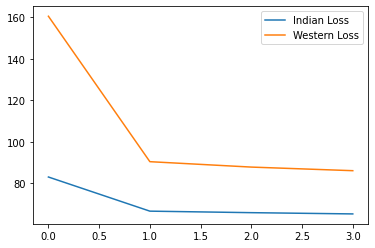

[5,     1] loss: 69.731
[5,     2] loss: 67.356
[5,     3] loss: 66.996
[5,     4] loss: 62.540
[5,     5] loss: 63.793
[5,     6] loss: 68.433
[5,     7] loss: 63.894
[5,     8] loss: 62.459
[5,     9] loss: 61.608
[5,    10] loss: 71.453
[5,    11] loss: 69.626
[5,    12] loss: 60.840
[5,    13] loss: 70.415
[5,    14] loss: 72.216
[5,    15] loss: 66.403
[5,    16] loss: 68.941
[5,    17] loss: 68.091
[5,    18] loss: 62.793
[5,    19] loss: 63.094
[5,    20] loss: 59.607
[5,    21] loss: 68.109
[5,    22] loss: 68.779
[5,    23] loss: 63.439
[5,    24] loss: 67.893
[5,    25] loss: 58.080
[5,    26] loss: 65.365
[5,    27] loss: 62.200
[5,    28] loss: 71.080
[5,    29] loss: 59.791
[5,    30] loss: 67.130
[5,    31] loss: 63.174
[5,    32] loss: 71.545
[5,    33] loss: 67.081
[5,    34] loss: 65.014
[5,    35] loss: 63.497
[5,    36] loss: 62.754
[5,    37] loss: 63.170
[5,    38] loss: 69.035
[5,    39] loss: 63.297
[5,    40] loss: 69.678
[5,    41] loss: 67.577
[5,    42] loss:

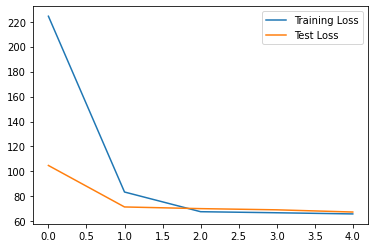

LOSS of the network on the test images: 1151 %
Mean of the network on the Indian images after epoch 4 is 63.963108486599396
LOSS of the network on the test images: 748 %
Mean of the network on the Western images after epoch 4 is 83.1810811360677


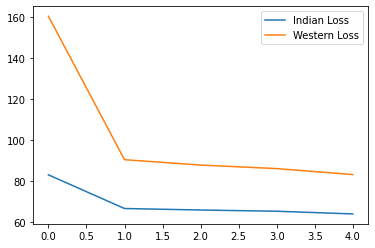

[6,     1] loss: 67.419
[6,     2] loss: 66.119
[6,     3] loss: 64.923
[6,     4] loss: 61.199
[6,     5] loss: 62.056
[6,     6] loss: 66.785
[6,     7] loss: 62.024
[6,     8] loss: 60.995
[6,     9] loss: 59.254
[6,    10] loss: 69.772
[6,    11] loss: 67.684
[6,    12] loss: 59.472
[6,    13] loss: 68.235
[6,    14] loss: 69.210
[6,    15] loss: 64.312
[6,    16] loss: 66.847
[6,    17] loss: 65.351
[6,    18] loss: 60.619
[6,    19] loss: 61.368
[6,    20] loss: 58.712
[6,    21] loss: 64.607
[6,    22] loss: 65.670
[6,    23] loss: 61.585
[6,    24] loss: 65.610
[6,    25] loss: 56.350
[6,    26] loss: 63.407
[6,    27] loss: 60.277
[6,    28] loss: 68.543
[6,    29] loss: 56.979
[6,    30] loss: 63.639
[6,    31] loss: 60.208
[6,    32] loss: 68.360
[6,    33] loss: 64.513
[6,    34] loss: 63.093
[6,    35] loss: 62.281
[6,    36] loss: 60.219
[6,    37] loss: 61.050
[6,    38] loss: 64.870
[6,    39] loss: 61.081
[6,    40] loss: 66.113
[6,    41] loss: 63.715
[6,    42] loss:

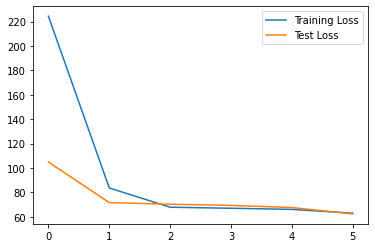

LOSS of the network on the test images: 1082 %
Mean of the network on the Indian images after epoch 5 is 60.11142773098416
LOSS of the network on the test images: 671 %
Mean of the network on the Western images after epoch 5 is 74.56030697292752


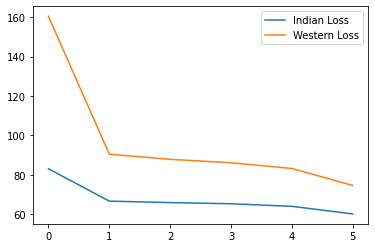

[7,     1] loss: 61.244
[7,     2] loss: 61.270
[7,     3] loss: 58.194
[7,     4] loss: 55.752
[7,     5] loss: 57.161
[7,     6] loss: 61.935
[7,     7] loss: 58.122
[7,     8] loss: 56.138
[7,     9] loss: 53.057
[7,    10] loss: 64.414
[7,    11] loss: 63.043
[7,    12] loss: 55.482
[7,    13] loss: 63.496
[7,    14] loss: 62.171
[7,    15] loss: 58.184
[7,    16] loss: 61.704
[7,    17] loss: 58.907
[7,    18] loss: 57.110
[7,    19] loss: 57.682
[7,    20] loss: 55.252
[7,    21] loss: 59.731
[7,    22] loss: 59.727
[7,    23] loss: 56.545
[7,    24] loss: 60.026
[7,    25] loss: 53.282
[7,    26] loss: 59.752
[7,    27] loss: 55.138
[7,    28] loss: 62.643
[7,    29] loss: 54.098
[7,    30] loss: 55.178
[7,    31] loss: 58.064
[7,    32] loss: 61.561
[7,    33] loss: 59.666
[7,    34] loss: 58.295
[7,    35] loss: 58.519
[7,    36] loss: 55.861
[7,    37] loss: 55.361
[7,    38] loss: 60.112
[7,    39] loss: 58.360
[7,    40] loss: 62.461
[7,    41] loss: 58.254
[7,    42] loss:

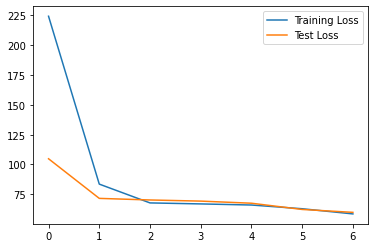

LOSS of the network on the test images: 1051 %
Mean of the network on the Indian images after epoch 6 is 58.43609979417589
LOSS of the network on the test images: 632 %
Mean of the network on the Western images after epoch 6 is 70.2642199198405


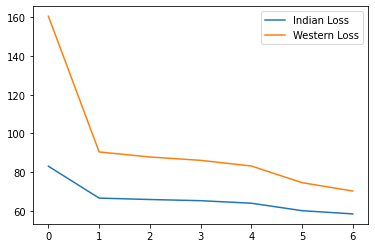

[8,     1] loss: 57.949
[8,     2] loss: 59.321
[8,     3] loss: 55.564
[8,     4] loss: 53.822
[8,     5] loss: 55.347
[8,     6] loss: 59.281
[8,     7] loss: 56.096
[8,     8] loss: 54.326
[8,     9] loss: 50.377
[8,    10] loss: 61.475
[8,    11] loss: 60.595
[8,    12] loss: 53.781
[8,    13] loss: 61.078
[8,    14] loss: 59.482
[8,    15] loss: 56.048
[8,    16] loss: 59.065
[8,    17] loss: 56.934
[8,    18] loss: 55.681
[8,    19] loss: 55.201
[8,    20] loss: 53.999
[8,    21] loss: 57.686
[8,    22] loss: 57.595
[8,    23] loss: 54.712
[8,    24] loss: 58.088
[8,    25] loss: 51.834
[8,    26] loss: 57.839
[8,    27] loss: 53.664
[8,    28] loss: 58.811
[8,    29] loss: 52.396
[8,    30] loss: 52.776
[8,    31] loss: 55.423
[8,    32] loss: 59.323
[8,    33] loss: 55.814
[8,    34] loss: 57.172
[8,    35] loss: 56.187
[8,    36] loss: 53.658
[8,    37] loss: 53.475
[8,    38] loss: 57.915
[8,    39] loss: 56.233
[8,    40] loss: 60.193
[8,    41] loss: 55.695
[8,    42] loss:

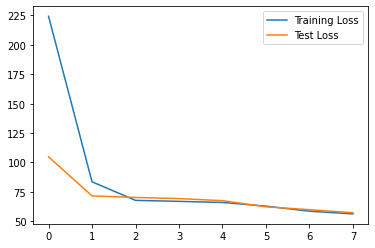

LOSS of the network on the test images: 1011 %
Mean of the network on the Indian images after epoch 7 is 56.20630921257867
LOSS of the network on the test images: 601 %
Mean of the network on the Western images after epoch 7 is 66.78833346896701


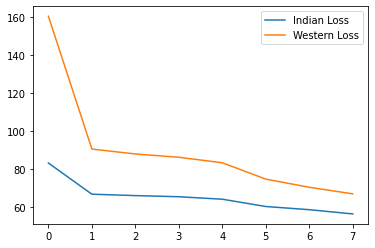

[9,     1] loss: 55.122
[9,     2] loss: 56.162
[9,     3] loss: 53.166
[9,     4] loss: 51.381
[9,     5] loss: 52.912
[9,     6] loss: 56.303
[9,     7] loss: 52.950
[9,     8] loss: 51.606
[9,     9] loss: 48.848
[9,    10] loss: 58.364
[9,    11] loss: 58.586
[9,    12] loss: 51.530
[9,    13] loss: 58.375
[9,    14] loss: 56.703
[9,    15] loss: 53.776
[9,    16] loss: 56.188
[9,    17] loss: 54.849
[9,    18] loss: 52.195
[9,    19] loss: 51.778
[9,    20] loss: 51.465
[9,    21] loss: 53.702
[9,    22] loss: 54.282
[9,    23] loss: 52.437
[9,    24] loss: 55.090
[9,    25] loss: 49.876
[9,    26] loss: 55.684
[9,    27] loss: 51.545
[9,    28] loss: 54.041
[9,    29] loss: 49.593
[9,    30] loss: 49.869
[9,    31] loss: 53.597
[9,    32] loss: 55.132
[9,    33] loss: 52.615
[9,    34] loss: 54.878
[9,    35] loss: 52.788
[9,    36] loss: 51.536
[9,    37] loss: 50.380
[9,    38] loss: 56.128
[9,    39] loss: 52.847
[9,    40] loss: 55.954
[9,    41] loss: 53.488
[9,    42] loss:

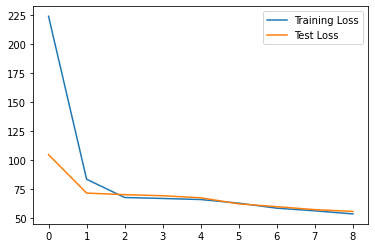

LOSS of the network on the test images: 991 %
Mean of the network on the Indian images after epoch 8 is 55.069289949205185
LOSS of the network on the test images: 576 %
Mean of the network on the Western images after epoch 8 is 64.08375846015082


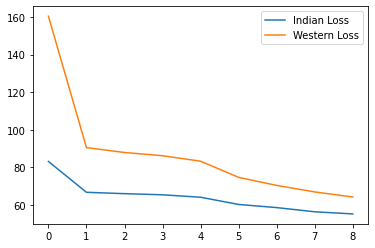

[10,     1] loss: 53.171
[10,     2] loss: 53.939
[10,     3] loss: 51.658
[10,     4] loss: 49.207
[10,     5] loss: 51.744
[10,     6] loss: 54.222
[10,     7] loss: 51.258
[10,     8] loss: 49.602
[10,     9] loss: 46.189
[10,    10] loss: 57.172
[10,    11] loss: 54.840
[10,    12] loss: 50.458
[10,    13] loss: 55.151
[10,    14] loss: 54.548
[10,    15] loss: 52.181
[10,    16] loss: 53.851
[10,    17] loss: 52.342
[10,    18] loss: 50.597
[10,    19] loss: 49.616
[10,    20] loss: 49.721
[10,    21] loss: 51.243
[10,    22] loss: 52.194
[10,    23] loss: 51.193
[10,    24] loss: 51.868
[10,    25] loss: 48.679
[10,    26] loss: 52.316
[10,    27] loss: 48.841
[10,    28] loss: 52.495
[10,    29] loss: 47.394
[10,    30] loss: 48.640
[10,    31] loss: 51.565
[10,    32] loss: 52.596
[10,    33] loss: 50.777
[10,    34] loss: 52.785
[10,    35] loss: 51.288
[10,    36] loss: 49.648
[10,    37] loss: 48.797
[10,    38] loss: 54.279
[10,    39] loss: 51.232
[10,    40] loss: 53.695


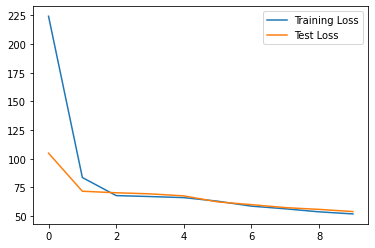

LOSS of the network on the test images: 961 %
Mean of the network on the Indian images after epoch 9 is 53.44258541531033
LOSS of the network on the test images: 553 %
Mean of the network on the Western images after epoch 9 is 61.45500479804145


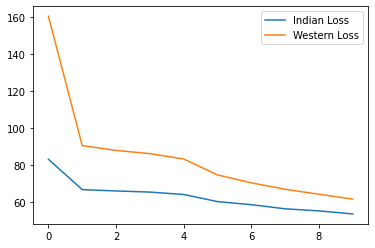

[11,     1] loss: 51.235
[11,     2] loss: 52.546
[11,     3] loss: 50.141
[11,     4] loss: 47.952
[11,     5] loss: 50.726
[11,     6] loss: 52.757
[11,     7] loss: 50.067
[11,     8] loss: 48.313
[11,     9] loss: 44.960
[11,    10] loss: 55.798
[11,    11] loss: 53.216
[11,    12] loss: 49.274
[11,    13] loss: 53.319
[11,    14] loss: 52.755
[11,    15] loss: 50.496
[11,    16] loss: 52.346
[11,    17] loss: 50.826
[11,    18] loss: 49.434
[11,    19] loss: 48.062
[11,    20] loss: 48.734
[11,    21] loss: 49.366
[11,    22] loss: 50.850
[11,    23] loss: 49.743
[11,    24] loss: 50.706
[11,    25] loss: 47.423
[11,    26] loss: 50.892
[11,    27] loss: 47.874
[11,    28] loss: 50.628
[11,    29] loss: 46.600
[11,    30] loss: 46.868
[11,    31] loss: 50.123
[11,    32] loss: 51.203
[11,    33] loss: 48.931
[11,    34] loss: 51.612
[11,    35] loss: 49.731
[11,    36] loss: 48.292
[11,    37] loss: 47.526
[11,    38] loss: 53.009
[11,    39] loss: 50.027
[11,    40] loss: 51.823


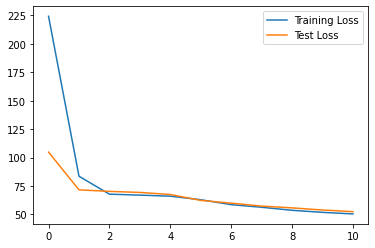

LOSS of the network on the test images: 941 %
Mean of the network on the Indian images after epoch 10 is 52.32666142781576
LOSS of the network on the test images: 532 %
Mean of the network on the Western images after epoch 10 is 59.22121556599935


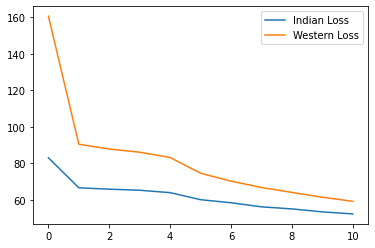

[12,     1] loss: 49.741
[12,     2] loss: 50.827
[12,     3] loss: 48.817
[12,     4] loss: 46.541
[12,     5] loss: 49.391
[12,     6] loss: 51.215
[12,     7] loss: 48.455
[12,     8] loss: 46.934
[12,     9] loss: 43.772
[12,    10] loss: 54.057
[12,    11] loss: 51.969
[12,    12] loss: 47.885
[12,    13] loss: 52.101
[12,    14] loss: 51.455
[12,    15] loss: 49.327
[12,    16] loss: 51.207
[12,    17] loss: 50.222
[12,    18] loss: 48.348
[12,    19] loss: 47.148
[12,    20] loss: 48.138
[12,    21] loss: 47.866
[12,    22] loss: 49.909
[12,    23] loss: 48.364
[12,    24] loss: 49.554
[12,    25] loss: 46.314
[12,    26] loss: 49.208
[12,    27] loss: 47.055
[12,    28] loss: 48.962
[12,    29] loss: 45.692
[12,    30] loss: 45.819
[12,    31] loss: 48.476
[12,    32] loss: 50.143
[12,    33] loss: 48.166
[12,    34] loss: 50.182
[12,    35] loss: 49.077
[12,    36] loss: 47.281
[12,    37] loss: 46.267
[12,    38] loss: 52.424
[12,    39] loss: 48.759
[12,    40] loss: 50.803


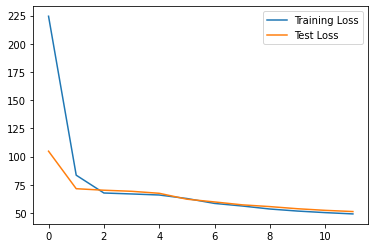

LOSS of the network on the test images: 927 %
Mean of the network on the Indian images after epoch 11 is 51.52155621846517
LOSS of the network on the test images: 517 %
Mean of the network on the Western images after epoch 11 is 57.5069457160102


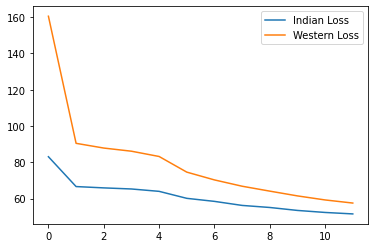

[13,     1] loss: 48.480
[13,     2] loss: 49.393
[13,     3] loss: 47.608
[13,     4] loss: 45.584
[13,     5] loss: 48.365
[13,     6] loss: 49.906
[13,     7] loss: 47.221
[13,     8] loss: 45.614
[13,     9] loss: 42.763
[13,    10] loss: 52.545
[13,    11] loss: 50.457
[13,    12] loss: 46.920
[13,    13] loss: 50.638
[13,    14] loss: 50.111
[13,    15] loss: 48.272
[13,    16] loss: 49.967
[13,    17] loss: 48.807
[13,    18] loss: 47.103
[13,    19] loss: 45.688
[13,    20] loss: 47.208
[13,    21] loss: 46.559
[13,    22] loss: 48.537
[13,    23] loss: 47.318
[13,    24] loss: 48.321
[13,    25] loss: 45.356
[13,    26] loss: 47.967
[13,    27] loss: 45.944
[13,    28] loss: 47.727
[13,    29] loss: 44.666
[13,    30] loss: 44.629
[13,    31] loss: 47.382
[13,    32] loss: 48.809
[13,    33] loss: 47.031
[13,    34] loss: 49.043
[13,    35] loss: 47.863
[13,    36] loss: 46.363
[13,    37] loss: 45.079
[13,    38] loss: 51.256
[13,    39] loss: 48.000
[13,    40] loss: 49.452


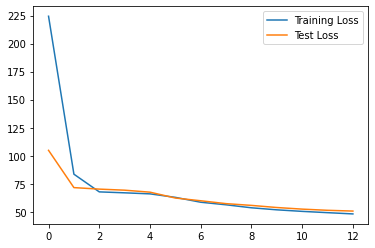

LOSS of the network on the test images: 919 %
Mean of the network on the Indian images after epoch 12 is 51.08893267313639
LOSS of the network on the test images: 505 %
Mean of the network on the Western images after epoch 12 is 56.197536044650604


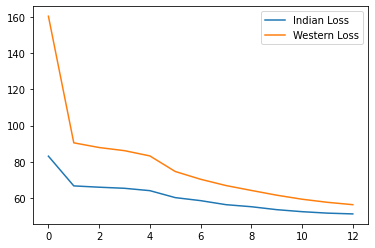

[14,     1] loss: 47.594
[14,     2] loss: 48.173
[14,     3] loss: 46.853
[14,     4] loss: 44.662
[14,     5] loss: 47.785
[14,     6] loss: 48.904
[14,     7] loss: 46.318
[14,     8] loss: 44.825
[14,     9] loss: 41.989
[14,    10] loss: 51.344
[14,    11] loss: 49.431
[14,    12] loss: 46.226
[14,    13] loss: 49.581
[14,    14] loss: 49.171
[14,    15] loss: 47.440
[14,    16] loss: 49.013
[14,    17] loss: 48.074
[14,    18] loss: 46.364
[14,    19] loss: 44.507
[14,    20] loss: 46.636
[14,    21] loss: 45.553
[14,    22] loss: 47.560
[14,    23] loss: 46.411
[14,    24] loss: 47.271
[14,    25] loss: 44.620
[14,    26] loss: 46.916
[14,    27] loss: 44.889
[14,    28] loss: 46.700
[14,    29] loss: 43.701
[14,    30] loss: 43.574
[14,    31] loss: 46.495
[14,    32] loss: 47.634
[14,    33] loss: 45.827
[14,    34] loss: 48.073
[14,    35] loss: 46.640
[14,    36] loss: 45.306
[14,    37] loss: 44.131
[14,    38] loss: 49.963
[14,    39] loss: 47.010
[14,    40] loss: 48.353


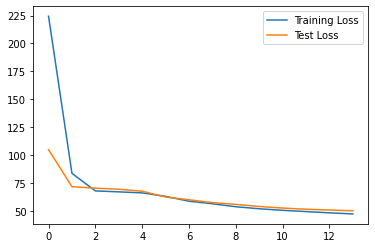

LOSS of the network on the test images: 909 %
Mean of the network on the Indian images after epoch 13 is 50.52863523695204
LOSS of the network on the test images: 495 %
Mean of the network on the Western images after epoch 13 is 55.03703350490994


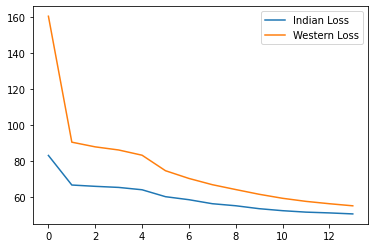

[15,     1] loss: 46.693
[15,     2] loss: 47.055
[15,     3] loss: 45.979
[15,     4] loss: 43.843
[15,     5] loss: 47.036
[15,     6] loss: 47.899
[15,     7] loss: 45.475
[15,     8] loss: 44.021
[15,     9] loss: 41.201
[15,    10] loss: 50.216
[15,    11] loss: 48.388
[15,    12] loss: 45.505
[15,    13] loss: 48.562
[15,    14] loss: 48.148
[15,    15] loss: 46.732
[15,    16] loss: 47.904
[15,    17] loss: 46.957
[15,    18] loss: 45.627
[15,    19] loss: 43.611
[15,    20] loss: 45.831
[15,    21] loss: 44.655
[15,    22] loss: 46.713
[15,    23] loss: 45.471
[15,    24] loss: 46.431
[15,    25] loss: 43.787
[15,    26] loss: 46.094
[15,    27] loss: 43.976
[15,    28] loss: 45.727
[15,    29] loss: 42.998
[15,    30] loss: 42.674
[15,    31] loss: 45.828
[15,    32] loss: 46.765
[15,    33] loss: 44.926
[15,    34] loss: 47.175
[15,    35] loss: 45.798
[15,    36] loss: 44.529
[15,    37] loss: 43.304
[15,    38] loss: 48.965
[15,    39] loss: 46.124
[15,    40] loss: 47.477


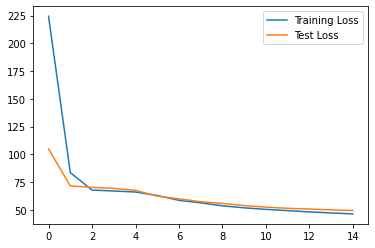

LOSS of the network on the test images: 900 %
Mean of the network on the Indian images after epoch 14 is 50.02301004197862
LOSS of the network on the test images: 487 %
Mean of the network on the Western images after epoch 14 is 54.18797175089518


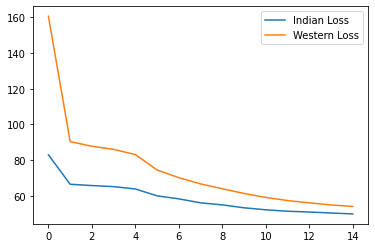

[16,     1] loss: 45.934
[16,     2] loss: 46.403
[16,     3] loss: 45.709
[16,     4] loss: 43.180
[16,     5] loss: 46.662
[16,     6] loss: 46.983
[16,     7] loss: 44.987
[16,     8] loss: 43.101
[16,     9] loss: 40.963
[16,    10] loss: 49.006
[16,    11] loss: 47.722
[16,    12] loss: 44.788
[16,    13] loss: 47.713
[16,    14] loss: 47.205
[16,    15] loss: 45.944
[16,    16] loss: 47.005
[16,    17] loss: 45.602
[16,    18] loss: 44.583
[16,    19] loss: 43.017
[16,    20] loss: 45.062
[16,    21] loss: 43.605
[16,    22] loss: 45.979
[16,    23] loss: 44.689
[16,    24] loss: 45.963
[16,    25] loss: 43.148
[16,    26] loss: 45.561
[16,    27] loss: 43.245
[16,    28] loss: 45.149
[16,    29] loss: 42.368
[16,    30] loss: 42.154
[16,    31] loss: 45.114
[16,    32] loss: 46.031
[16,    33] loss: 44.211
[16,    34] loss: 46.650
[16,    35] loss: 45.224
[16,    36] loss: 43.597
[16,    37] loss: 42.842
[16,    38] loss: 47.943
[16,    39] loss: 45.486
[16,    40] loss: 46.355


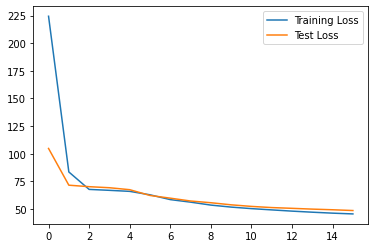

LOSS of the network on the test images: 888 %
Mean of the network on the Indian images after epoch 15 is 49.36730088127984
LOSS of the network on the test images: 479 %
Mean of the network on the Western images after epoch 15 is 53.26830630832248


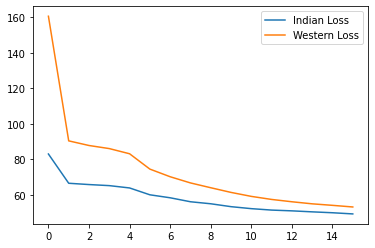

[17,     1] loss: 45.044
[17,     2] loss: 45.833
[17,     3] loss: 44.388
[17,     4] loss: 43.209
[17,     5] loss: 45.198
[17,     6] loss: 46.496
[17,     7] loss: 43.777
[17,     8] loss: 42.635
[17,     9] loss: 39.993
[17,    10] loss: 48.305
[17,    11] loss: 46.838
[17,    12] loss: 44.259
[17,    13] loss: 47.097
[17,    14] loss: 46.512
[17,    15] loss: 45.422
[17,    16] loss: 46.130
[17,    17] loss: 45.066
[17,    18] loss: 43.775
[17,    19] loss: 42.466
[17,    20] loss: 44.482
[17,    21] loss: 42.986
[17,    22] loss: 45.398
[17,    23] loss: 43.993
[17,    24] loss: 45.425
[17,    25] loss: 42.515
[17,    26] loss: 45.072
[17,    27] loss: 42.520
[17,    28] loss: 44.723
[17,    29] loss: 41.891
[17,    30] loss: 41.645
[17,    31] loss: 44.560
[17,    32] loss: 45.396
[17,    33] loss: 43.520
[17,    34] loss: 45.918
[17,    35] loss: 44.159
[17,    36] loss: 42.829
[17,    37] loss: 41.885
[17,    38] loss: 47.258
[17,    39] loss: 44.607
[17,    40] loss: 45.636


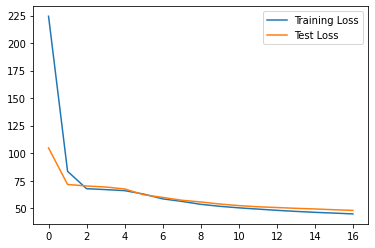

LOSS of the network on the test images: 878 %
Mean of the network on the Indian images after epoch 16 is 48.818768395317925
LOSS of the network on the test images: 471 %
Mean of the network on the Western images after epoch 16 is 52.34357198079427


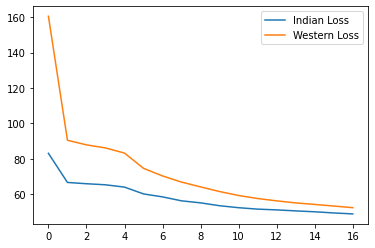

[18,     1] loss: 44.250
[18,     2] loss: 44.919
[18,     3] loss: 43.551
[18,     4] loss: 42.464
[18,     5] loss: 44.329
[18,     6] loss: 45.553
[18,     7] loss: 43.074
[18,     8] loss: 41.822
[18,     9] loss: 39.326
[18,    10] loss: 47.244
[18,    11] loss: 46.035
[18,    12] loss: 43.623
[18,    13] loss: 46.089
[18,    14] loss: 45.687
[18,    15] loss: 44.635
[18,    16] loss: 45.295
[18,    17] loss: 44.326
[18,    18] loss: 43.132
[18,    19] loss: 41.785
[18,    20] loss: 43.925
[18,    21] loss: 42.140
[18,    22] loss: 44.513
[18,    23] loss: 43.284
[18,    24] loss: 44.686
[18,    25] loss: 41.768
[18,    26] loss: 44.322
[18,    27] loss: 41.775
[18,    28] loss: 43.921
[18,    29] loss: 41.216
[18,    30] loss: 40.960
[18,    31] loss: 43.855
[18,    32] loss: 44.695
[18,    33] loss: 42.856
[18,    34] loss: 45.334
[18,    35] loss: 43.337
[18,    36] loss: 42.255
[18,    37] loss: 41.177
[18,    38] loss: 46.361
[18,    39] loss: 43.825
[18,    40] loss: 44.866


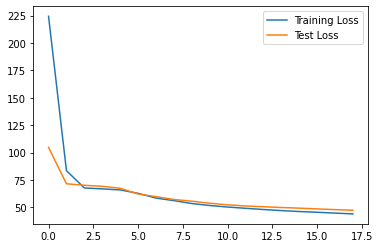

LOSS of the network on the test images: 866 %
Mean of the network on the Indian images after epoch 17 is 48.16571701897515
LOSS of the network on the test images: 465 %
Mean of the network on the Western images after epoch 17 is 51.76102193196615


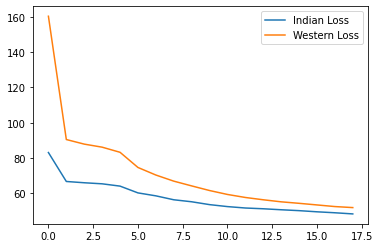

[19,     1] loss: 43.489
[19,     2] loss: 44.436
[19,     3] loss: 43.552
[19,     4] loss: 42.693
[19,     5] loss: 43.732
[19,     6] loss: 44.838
[19,     7] loss: 42.517
[19,     8] loss: 41.246
[19,     9] loss: 38.803
[19,    10] loss: 46.400
[19,    11] loss: 45.452
[19,    12] loss: 43.078
[19,    13] loss: 45.335
[19,    14] loss: 45.170
[19,    15] loss: 44.091
[19,    16] loss: 44.475
[19,    17] loss: 43.680
[19,    18] loss: 42.838
[19,    19] loss: 41.464
[19,    20] loss: 43.390
[19,    21] loss: 41.464
[19,    22] loss: 44.242
[19,    23] loss: 42.680
[19,    24] loss: 44.178
[19,    25] loss: 41.253
[19,    26] loss: 43.766
[19,    27] loss: 41.132
[19,    28] loss: 43.285
[19,    29] loss: 40.688
[19,    30] loss: 40.243
[19,    31] loss: 43.207
[19,    32] loss: 43.675
[19,    33] loss: 42.245
[19,    34] loss: 44.411
[19,    35] loss: 42.745
[19,    36] loss: 41.411
[19,    37] loss: 40.349
[19,    38] loss: 45.745
[19,    39] loss: 43.175
[19,    40] loss: 44.141


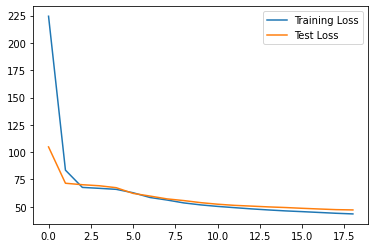

LOSS of the network on the test images: 864 %
Mean of the network on the Indian images after epoch 18 is 48.037614822387695
LOSS of the network on the test images: 460 %
Mean of the network on the Western images after epoch 18 is 51.17324786716037


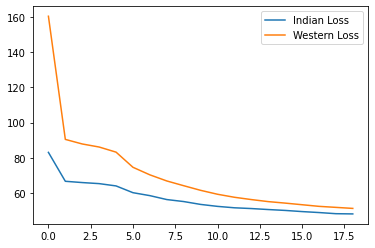

[20,     1] loss: 43.044
[20,     2] loss: 43.296
[20,     3] loss: 42.192
[20,     4] loss: 40.988
[20,     5] loss: 42.779
[20,     6] loss: 43.978
[20,     7] loss: 41.736
[20,     8] loss: 40.460
[20,     9] loss: 38.151
[20,    10] loss: 45.469
[20,    11] loss: 44.481
[20,    12] loss: 42.487
[20,    13] loss: 44.437
[20,    14] loss: 44.331
[20,    15] loss: 43.193
[20,    16] loss: 43.792
[20,    17] loss: 42.726
[20,    18] loss: 42.162
[20,    19] loss: 40.626
[20,    20] loss: 42.715
[20,    21] loss: 40.623
[20,    22] loss: 43.181
[20,    23] loss: 41.907
[20,    24] loss: 43.353
[20,    25] loss: 40.523
[20,    26] loss: 42.825
[20,    27] loss: 40.364
[20,    28] loss: 42.487
[20,    29] loss: 39.836
[20,    30] loss: 39.607
[20,    31] loss: 42.332
[20,    32] loss: 42.911
[20,    33] loss: 41.326
[20,    34] loss: 43.693
[20,    35] loss: 42.077
[20,    36] loss: 40.885
[20,    37] loss: 39.540
[20,    38] loss: 44.871
[20,    39] loss: 42.707
[20,    40] loss: 43.537


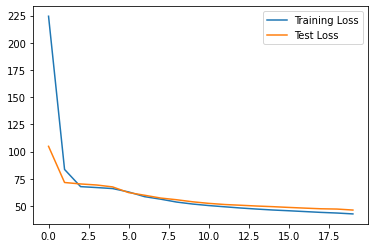

LOSS of the network on the test images: 848 %
Mean of the network on the Indian images after epoch 19 is 47.14745839436849
LOSS of the network on the test images: 450 %
Mean of the network on the Western images after epoch 19 is 50.07351938883463


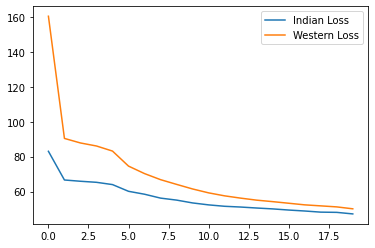

[21,     1] loss: 41.936
[21,     2] loss: 43.164
[21,     3] loss: 42.323
[21,     4] loss: 41.205
[21,     5] loss: 42.208
[21,     6] loss: 43.386
[21,     7] loss: 41.334
[21,     8] loss: 39.879
[21,     9] loss: 37.543
[21,    10] loss: 44.795
[21,    11] loss: 43.872
[21,    12] loss: 41.977
[21,    13] loss: 43.819
[21,    14] loss: 43.675
[21,    15] loss: 42.343
[21,    16] loss: 43.002
[21,    17] loss: 42.514
[21,    18] loss: 42.488
[21,    19] loss: 40.692
[21,    20] loss: 42.226
[21,    21] loss: 40.630
[21,    22] loss: 43.341
[21,    23] loss: 41.319
[21,    24] loss: 43.095
[21,    25] loss: 40.581
[21,    26] loss: 42.228
[21,    27] loss: 40.009
[21,    28] loss: 42.475
[21,    29] loss: 39.320
[21,    30] loss: 39.100
[21,    31] loss: 41.896
[21,    32] loss: 42.342
[21,    33] loss: 40.727
[21,    34] loss: 43.194
[21,    35] loss: 41.798
[21,    36] loss: 40.129
[21,    37] loss: 38.915
[21,    38] loss: 44.021
[21,    39] loss: 41.759
[21,    40] loss: 42.566


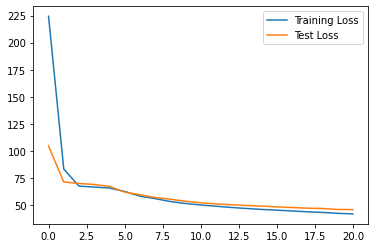

LOSS of the network on the test images: 848 %
Mean of the network on the Indian images after epoch 20 is 47.12618827819824
LOSS of the network on the test images: 449 %
Mean of the network on the Western images after epoch 20 is 49.90521579318576


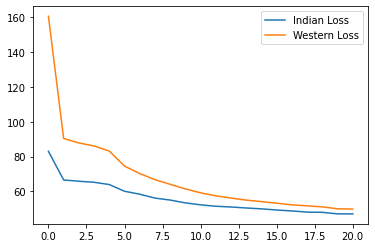

[22,     1] loss: 41.651
[22,     2] loss: 41.938
[22,     3] loss: 40.841
[22,     4] loss: 39.933
[22,     5] loss: 41.226
[22,     6] loss: 42.522
[22,     7] loss: 40.409
[22,     8] loss: 39.173
[22,     9] loss: 36.839
[22,    10] loss: 43.896
[22,    11] loss: 43.106
[22,    12] loss: 41.263
[22,    13] loss: 42.985
[22,    14] loss: 42.992
[22,    15] loss: 41.625
[22,    16] loss: 42.160
[22,    17] loss: 41.264
[22,    18] loss: 41.125
[22,    19] loss: 39.224
[22,    20] loss: 41.535
[22,    21] loss: 39.571
[22,    22] loss: 41.438
[22,    23] loss: 40.508
[22,    24] loss: 42.647
[22,    25] loss: 39.302
[22,    26] loss: 41.339
[22,    27] loss: 39.498
[22,    28] loss: 41.351
[22,    29] loss: 38.480
[22,    30] loss: 38.256
[22,    31] loss: 40.903
[22,    32] loss: 41.335
[22,    33] loss: 39.758
[22,    34] loss: 42.002
[22,    35] loss: 40.715
[22,    36] loss: 39.346
[22,    37] loss: 37.889
[22,    38] loss: 42.906
[22,    39] loss: 41.189
[22,    40] loss: 41.710


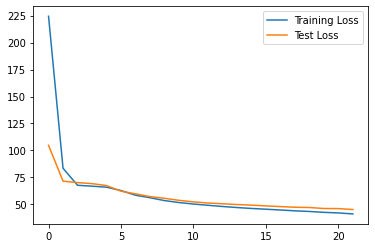

LOSS of the network on the test images: 832 %
Mean of the network on the Indian images after epoch 21 is 46.238320456610786
LOSS of the network on the test images: 439 %
Mean of the network on the Western images after epoch 21 is 48.8484001159668


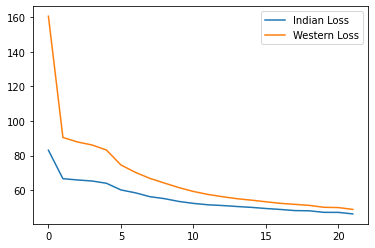

[23,     1] loss: 40.631
[23,     2] loss: 41.125
[23,     3] loss: 39.911
[23,     4] loss: 39.065
[23,     5] loss: 40.472
[23,     6] loss: 41.446
[23,     7] loss: 39.537
[23,     8] loss: 38.290
[23,     9] loss: 36.151
[23,    10] loss: 42.699
[23,    11] loss: 42.061
[23,    12] loss: 40.510
[23,    13] loss: 41.955
[23,    14] loss: 41.817
[23,    15] loss: 40.676
[23,    16] loss: 41.107
[23,    17] loss: 40.237
[23,    18] loss: 40.259
[23,    19] loss: 38.481
[23,    20] loss: 40.544
[23,    21] loss: 38.790
[23,    22] loss: 40.556
[23,    23] loss: 39.483
[23,    24] loss: 41.371
[23,    25] loss: 38.462
[23,    26] loss: 40.279
[23,    27] loss: 38.257
[23,    28] loss: 40.372
[23,    29] loss: 37.853
[23,    30] loss: 37.232
[23,    31] loss: 39.878
[23,    32] loss: 40.301
[23,    33] loss: 38.711
[23,    34] loss: 40.999
[23,    35] loss: 39.795
[23,    36] loss: 38.556
[23,    37] loss: 37.019
[23,    38] loss: 41.764
[23,    39] loss: 40.303
[23,    40] loss: 40.691


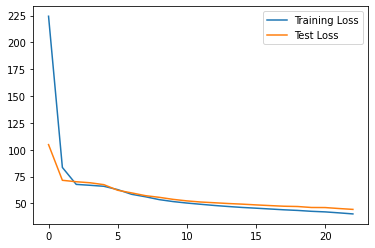

LOSS of the network on the test images: 812 %
Mean of the network on the Indian images after epoch 22 is 45.155540466308594
LOSS of the network on the test images: 435 %
Mean of the network on the Western images after epoch 22 is 48.441334618462456


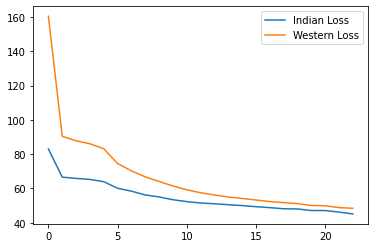

[24,     1] loss: 39.552
[24,     2] loss: 40.315
[24,     3] loss: 38.867
[24,     4] loss: 38.004
[24,     5] loss: 39.563
[24,     6] loss: 40.494
[24,     7] loss: 38.510
[24,     8] loss: 37.403
[24,     9] loss: 35.298
[24,    10] loss: 41.670
[24,    11] loss: 40.881
[24,    12] loss: 39.599
[24,    13] loss: 41.010
[24,    14] loss: 40.919
[24,    15] loss: 39.838
[24,    16] loss: 39.980
[24,    17] loss: 39.491
[24,    18] loss: 39.836
[24,    19] loss: 38.075
[24,    20] loss: 39.629
[24,    21] loss: 37.889
[24,    22] loss: 40.168
[24,    23] loss: 38.488
[24,    24] loss: 40.155
[24,    25] loss: 37.526
[24,    26] loss: 39.552
[24,    27] loss: 37.101
[24,    28] loss: 39.357
[24,    29] loss: 36.981
[24,    30] loss: 36.329
[24,    31] loss: 38.926
[24,    32] loss: 39.197
[24,    33] loss: 37.791
[24,    34] loss: 39.902
[24,    35] loss: 38.880
[24,    36] loss: 37.760
[24,    37] loss: 36.248
[24,    38] loss: 40.522
[24,    39] loss: 39.089
[24,    40] loss: 39.521


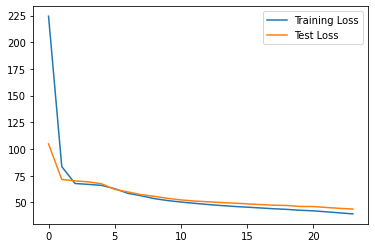

LOSS of the network on the test images: 802 %
Mean of the network on the Indian images after epoch 23 is 44.60467296176486
LOSS of the network on the test images: 427 %
Mean of the network on the Western images after epoch 23 is 47.483536614312065


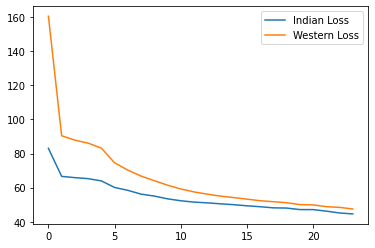

[25,     1] loss: 38.466
[25,     2] loss: 39.665
[25,     3] loss: 38.277
[25,     4] loss: 37.396
[25,     5] loss: 38.494
[25,     6] loss: 39.425
[25,     7] loss: 37.631
[25,     8] loss: 36.409
[25,     9] loss: 34.340
[25,    10] loss: 40.389
[25,    11] loss: 39.703
[25,    12] loss: 38.645
[25,    13] loss: 39.775
[25,    14] loss: 39.590
[25,    15] loss: 38.703
[25,    16] loss: 38.838
[25,    17] loss: 38.032
[25,    18] loss: 38.471
[25,    19] loss: 37.216
[25,    20] loss: 38.834
[25,    21] loss: 36.508
[25,    22] loss: 38.492
[25,    23] loss: 37.458
[25,    24] loss: 38.813
[25,    25] loss: 36.303
[25,    26] loss: 38.378
[25,    27] loss: 36.065
[25,    28] loss: 38.202
[25,    29] loss: 36.071
[25,    30] loss: 35.432
[25,    31] loss: 37.903
[25,    32] loss: 38.175
[25,    33] loss: 36.860
[25,    34] loss: 39.038
[25,    35] loss: 38.065
[25,    36] loss: 36.826
[25,    37] loss: 35.110
[25,    38] loss: 39.381
[25,    39] loss: 38.331
[25,    40] loss: 39.153


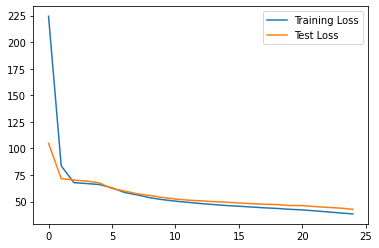

LOSS of the network on the test images: 783 %
Mean of the network on the Indian images after epoch 24 is 43.54265340169271
LOSS of the network on the test images: 414 %
Mean of the network on the Western images after epoch 24 is 46.018886142306854


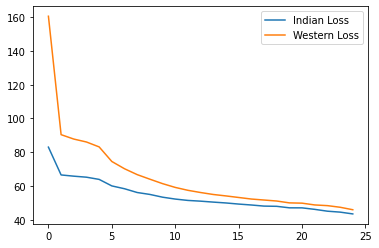

[26,     1] loss: 37.241
[26,     2] loss: 38.113
[26,     3] loss: 36.777
[26,     4] loss: 36.171
[26,     5] loss: 37.747
[26,     6] loss: 38.294
[26,     7] loss: 36.522
[26,     8] loss: 35.248
[26,     9] loss: 33.680
[26,    10] loss: 39.636
[26,    11] loss: 39.242
[26,    12] loss: 37.805
[26,    13] loss: 38.674
[26,    14] loss: 39.144
[26,    15] loss: 38.341
[26,    16] loss: 37.767
[26,    17] loss: 38.103
[26,    18] loss: 39.605
[26,    19] loss: 36.598
[26,    20] loss: 38.156
[26,    21] loss: 37.815
[26,    22] loss: 37.860
[26,    23] loss: 37.269
[26,    24] loss: 40.170
[26,    25] loss: 37.030
[26,    26] loss: 37.638
[26,    27] loss: 35.846
[26,    28] loss: 38.282
[26,    29] loss: 35.656
[26,    30] loss: 34.879
[26,    31] loss: 37.353
[26,    32] loss: 37.479
[26,    33] loss: 36.312
[26,    34] loss: 37.953
[26,    35] loss: 37.018
[26,    36] loss: 35.965
[26,    37] loss: 34.167
[26,    38] loss: 38.371
[26,    39] loss: 37.030
[26,    40] loss: 37.324


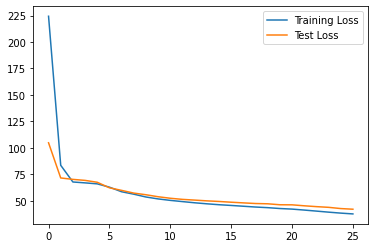

LOSS of the network on the test images: 773 %
Mean of the network on the Indian images after epoch 25 is 42.972603268093536
LOSS of the network on the test images: 407 %
Mean of the network on the Western images after epoch 25 is 45.278441535102


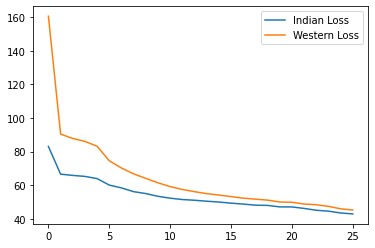

[27,     1] loss: 36.493
[27,     2] loss: 37.358
[27,     3] loss: 35.814
[27,     4] loss: 35.404
[27,     5] loss: 36.541
[27,     6] loss: 37.108
[27,     7] loss: 35.501
[27,     8] loss: 34.260
[27,     9] loss: 32.581
[27,    10] loss: 37.778
[27,    11] loss: 37.171
[27,    12] loss: 36.649
[27,    13] loss: 37.401
[27,    14] loss: 37.034
[27,    15] loss: 36.437
[27,    16] loss: 37.181
[27,    17] loss: 36.269
[27,    18] loss: 36.051
[27,    19] loss: 34.570
[27,    20] loss: 36.922
[27,    21] loss: 34.727
[27,    22] loss: 36.437
[27,    23] loss: 36.243
[27,    24] loss: 37.702
[27,    25] loss: 34.371
[27,    26] loss: 37.148
[27,    27] loss: 35.256
[27,    28] loss: 36.373
[27,    29] loss: 34.702
[27,    30] loss: 34.085
[27,    31] loss: 36.350
[27,    32] loss: 36.210
[27,    33] loss: 35.274
[27,    34] loss: 37.202
[27,    35] loss: 35.775
[27,    36] loss: 35.501
[27,    37] loss: 33.181
[27,    38] loss: 36.983
[27,    39] loss: 36.161
[27,    40] loss: 36.219


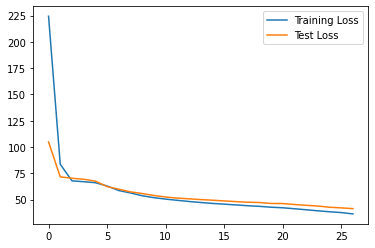

LOSS of the network on the test images: 762 %
Mean of the network on the Indian images after epoch 26 is 42.367037031385635
LOSS of the network on the test images: 398 %
Mean of the network on the Western images after epoch 26 is 44.23837746514214


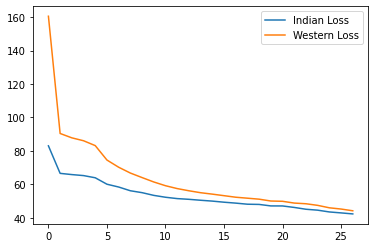

[28,     1] loss: 35.704
[28,     2] loss: 36.766
[28,     3] loss: 36.090
[28,     4] loss: 34.307
[28,     5] loss: 35.937
[28,     6] loss: 36.782
[28,     7] loss: 34.864
[28,     8] loss: 33.601
[28,     9] loss: 32.783
[28,    10] loss: 37.148
[28,    11] loss: 36.187
[28,    12] loss: 36.052
[28,    13] loss: 36.584
[28,    14] loss: 35.989
[28,    15] loss: 36.151
[28,    16] loss: 36.215
[28,    17] loss: 34.747
[28,    18] loss: 35.155
[28,    19] loss: 34.556
[28,    20] loss: 35.512
[28,    21] loss: 33.949
[28,    22] loss: 36.902
[28,    23] loss: 34.953
[28,    24] loss: 35.723
[28,    25] loss: 34.472
[28,    26] loss: 35.470
[28,    27] loss: 33.859
[28,    28] loss: 36.964
[28,    29] loss: 34.127
[28,    30] loss: 32.639
[28,    31] loss: 36.373
[28,    32] loss: 35.884
[28,    33] loss: 33.926
[28,    34] loss: 36.475
[28,    35] loss: 35.529
[28,    36] loss: 34.076
[28,    37] loss: 32.492
[28,    38] loss: 36.557
[28,    39] loss: 35.133
[28,    40] loss: 35.621


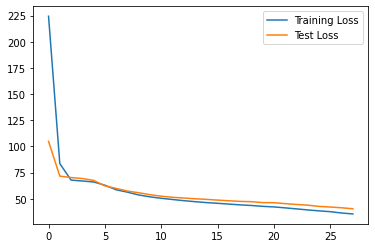

LOSS of the network on the test images: 742 %
Mean of the network on the Indian images after epoch 27 is 41.271533754136826
LOSS of the network on the test images: 392 %
Mean of the network on the Western images after epoch 27 is 43.56877136230469


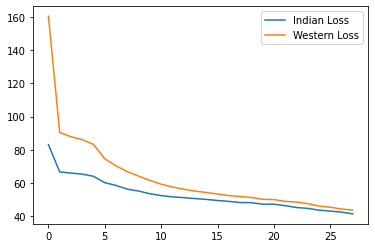

[29,     1] loss: 34.512
[29,     2] loss: 35.072
[29,     3] loss: 33.790
[29,     4] loss: 33.413
[29,     5] loss: 34.610
[29,     6] loss: 34.779
[29,     7] loss: 33.449
[29,     8] loss: 32.264
[29,     9] loss: 30.876
[29,    10] loss: 35.343
[29,    11] loss: 34.962
[29,    12] loss: 34.255
[29,    13] loss: 35.184
[29,    14] loss: 34.793
[29,    15] loss: 34.084
[29,    16] loss: 34.396
[29,    17] loss: 33.571
[29,    18] loss: 33.574
[29,    19] loss: 32.679
[29,    20] loss: 34.282
[29,    21] loss: 32.354
[29,    22] loss: 34.493
[29,    23] loss: 33.365
[29,    24] loss: 34.397
[29,    25] loss: 32.562
[29,    26] loss: 34.156
[29,    27] loss: 31.931
[29,    28] loss: 34.687
[29,    29] loss: 32.585
[29,    30] loss: 31.434
[29,    31] loss: 34.346
[29,    32] loss: 34.225
[29,    33] loss: 32.819
[29,    34] loss: 34.891
[29,    35] loss: 34.061
[29,    36] loss: 33.035
[29,    37] loss: 30.991
[29,    38] loss: 34.667
[29,    39] loss: 34.005
[29,    40] loss: 34.027


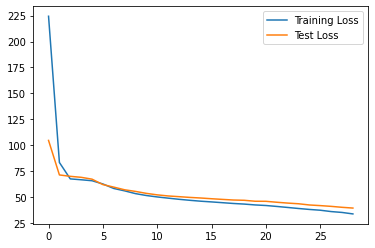

LOSS of the network on the test images: 730 %
Mean of the network on the Indian images after epoch 28 is 40.59801334804959
LOSS of the network on the test images: 384 %
Mean of the network on the Western images after epoch 28 is 42.66863081190321


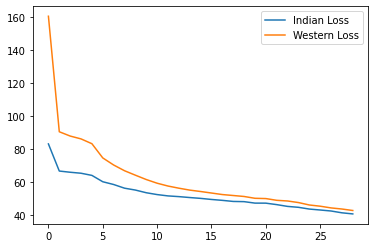

[30,     1] loss: 33.566
[30,     2] loss: 33.818
[30,     3] loss: 32.742
[30,     4] loss: 32.489
[30,     5] loss: 33.472
[30,     6] loss: 33.676
[30,     7] loss: 32.398
[30,     8] loss: 31.104
[30,     9] loss: 29.994
[30,    10] loss: 34.112
[30,    11] loss: 33.655
[30,    12] loss: 33.232
[30,    13] loss: 33.939
[30,    14] loss: 33.677
[30,    15] loss: 33.089
[30,    16] loss: 33.253
[30,    17] loss: 32.505
[30,    18] loss: 32.525
[30,    19] loss: 31.665
[30,    20] loss: 33.220
[30,    21] loss: 31.324
[30,    22] loss: 33.400
[30,    23] loss: 32.332
[30,    24] loss: 33.289
[30,    25] loss: 31.466
[30,    26] loss: 32.954
[30,    27] loss: 30.905
[30,    28] loss: 33.408
[30,    29] loss: 31.623
[30,    30] loss: 30.367
[30,    31] loss: 33.135
[30,    32] loss: 33.070
[30,    33] loss: 31.888
[30,    34] loss: 33.639
[30,    35] loss: 32.972
[30,    36] loss: 32.150
[30,    37] loss: 29.889
[30,    38] loss: 33.580
[30,    39] loss: 33.189
[30,    40] loss: 32.792


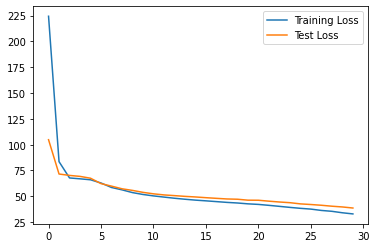

LOSS of the network on the test images: 714 %
Mean of the network on the Indian images after epoch 29 is 39.708060370551216
LOSS of the network on the test images: 371 %
Mean of the network on the Western images after epoch 29 is 41.26308102077908


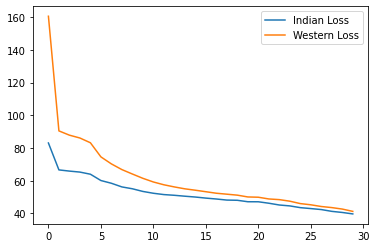

Finished Training


In [28]:
train_loss_graph = []
test_loss_graph = []

indian_loss_graph = []
western_loss_graph = []

for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    total_Loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels, fileNames = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        total_Loss += loss.item()

        if i % print_every == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / print_every))
            running_loss = 0.0
    
    print('LOSS of the network on the train images after epoch {} is {}'.format(epoch, total_Loss) )
    if reduction_loss == "mean":
      total_Loss = total_Loss/i
      print('Mean of the network on the train images after epoch {} is {}'.format(epoch, total_Loss) )
    
    train_loss_graph.append(total_Loss)
    correct = 0
    total = 0
    running_loss = 0.0
    total_Loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for j, data in enumerate(testloader,0):
            inputs, labels, fileNames = data
            inputs, labels = inputs.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(inputs)
            loss = criterion(outputs, inputs)
            running_loss += loss.item()
            total_Loss += loss.item()

    print('LOSS of the network on the test images: %d %%' % (total_Loss))
    if reduction_loss == "mean":
      total_Loss = total_Loss/j
      print('Mean of the network on the train images after epoch {} is {}'.format(epoch, total_Loss) )
      
    
    test_loss_graph.append(total_Loss)
    visualize(train_loss_graph, test_loss_graph)


    running_loss = 0.0
    total_Loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for j, data in enumerate(indian_loader,0):
            inputs, labels, fileNames = data
            inputs, labels = inputs.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(inputs)
            loss = criterion(outputs, inputs)
            running_loss += loss.item()
            total_Loss += loss.item()

    print('LOSS of the network on the test images: %d %%' % (total_Loss))
    if reduction_loss == "mean":
      total_Loss = total_Loss/j
      print('Mean of the network on the Indian images after epoch {} is {}'.format(epoch, total_Loss) )

    indian_loss_graph.append(total_Loss)

    running_loss = 0.0
    total_Loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for j, data in enumerate(western_loader,0):
            inputs, labels, fileNames = data
            inputs, labels = inputs.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(inputs)
            loss = criterion(outputs, inputs)
            running_loss += loss.item()
            total_Loss += loss.item()

    print('LOSS of the network on the test images: %d %%' % (total_Loss))
    if reduction_loss == "mean":
      total_Loss = total_Loss/j
      print('Mean of the network on the Western images after epoch {} is {}'.format(epoch, total_Loss) )

    western_loss_graph.append(total_Loss)

    visualize_class_loss(indian_loss_graph, western_loss_graph)
          

print('Finished Training')

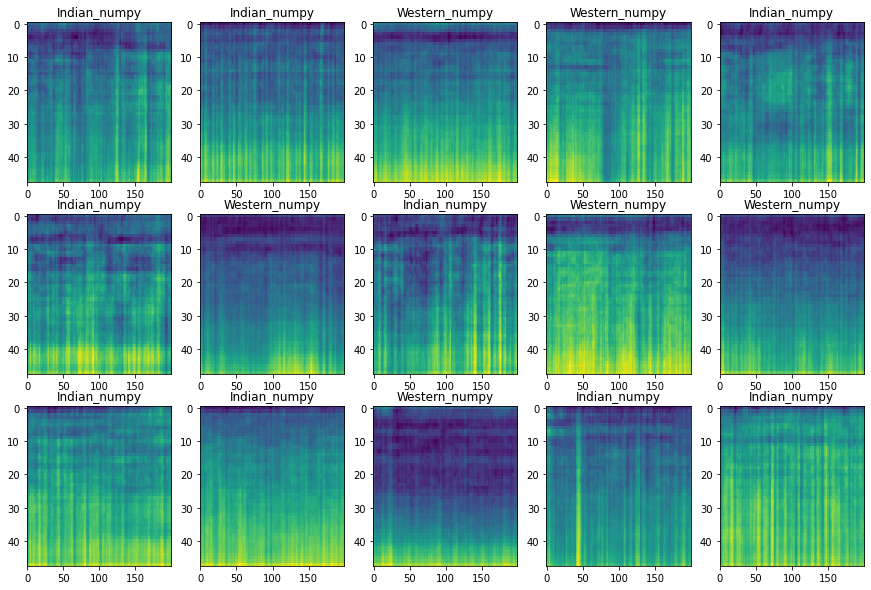

In [29]:
# get some random training images
dataiter = iter(testloader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        image, labels = image.to(device), labels.to(device)
        output_img = net(image.unsqueeze(dim=0))
        ax.imshow(mel_display(output_img.detach().cpu()), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

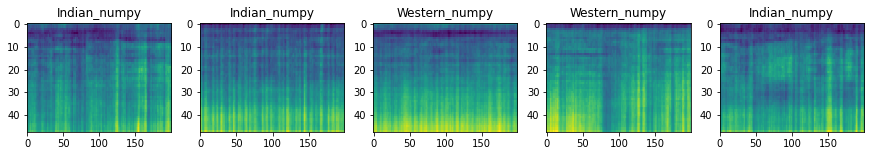

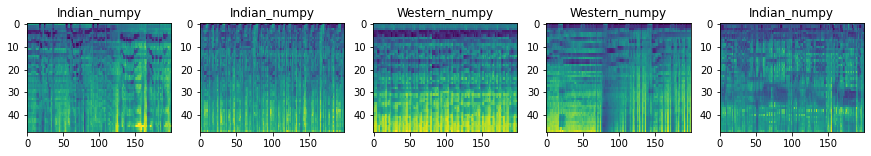

In [30]:
# get some random training images
outputs=[]
dataiter = iter(testloader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(1, 5, figsize=(15, 2))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        image, labels = image.to(device), labels.to(device)
        output_img = net(image.unsqueeze(dim=0))
        ax.imshow(mel_display(output_img.detach().cpu()), interpolation='nearest', aspect='auto') # add image
        outputs.append((mel_display(image.detach().cpu().unsqueeze(dim=0)),arthopod_types[label.item()] ))
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

fig, axis = plt.subplots(1, 5, figsize=(15, 2))
for ax , (image, label) in zip(axis.flat, outputs):
    ax.imshow(image, interpolation='nearest', aspect='auto') # add image
    ax.set(title = f"{label}") # add label
    
        

In [31]:
torch.save(net.state_dict(), os.path.join(BASE_PATH, "final_model.pt"))

Start evaluation - Test model

In [32]:
model = RecurrentAutoencoder(seq_len, input_bins, AE_encoded_dim, device=device)
model.load_state_dict(torch.load(os.path.join(BASE_PATH, "final_model.pt"), map_location=device))

<All keys matched successfully>

Combined data set recinstruction

In [33]:
combined_dataset = MEL_Dataset(dataDF,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR),transform)
combinedloader = torch.utils.data.DataLoader(combined_dataset, batch_size=batch_size)

In [ ]:
# dataDF
# dataDF.loc[1, 'labels']
# classes
# os.path.join(BASE_PATH, "Activations_64", str(classes[label]))

In [ ]:
for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_64",  str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_128", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "reconstructions", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "originals",  str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

In [ ]:
id = 0
with torch.no_grad():
    for data in combinedloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        output_l2, output_l1 = model.encoder(inputs)
        output = model(inputs)
        output_l2 = output_l2.detach().cpu().numpy()
        output_l1 = output_l1.detach().cpu().numpy()
        output = output.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        
        for  arr64, arr128, arr48, label in zip(output_l2, output_l1, output, labels):
          print(os.path.join(BASE_PATH, "Activations_64", str(classes[label]), str(id) + ".npy"))
          np.save(os.path.join(BASE_PATH, "Activations_64", str(classes[label]), str(id) + ".npy"),np.transpose(arr64, (1,0)))
          np.save(os.path.join(BASE_PATH, "Activations_128", classes[label] ,  str(id) + ".npy" ), np.transpose(arr128, (1,0)))
          np.save(os.path.join(BASE_PATH, "reconstructions", classes[label] ,  str(id) + ".npy"), np.transpose(arr48, (1,0)))
          id = id + 1

Strict data separation

In [34]:
for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_64", "test", str(class_))
  #print("removing ", dir)
  for f in os.listdir(dir):
    #print("removing ", os.path.join(dir, f))
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_128", "test", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "reconstructions", "test", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "originals", "test", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))


for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_64", "training", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_128", "training", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "reconstructions", "training", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "originals", "training", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

In [ ]:
id_test = 0
with torch.no_grad():
    for data_test in testloader:
        inputs, labels, fileNames = data_test
        inputs, labels = inputs.to(device), labels.to(device)
        output_l2, output_l1 = model.encoder(inputs)
        output = model(inputs)
        output_l2 = output_l2.detach().cpu().numpy()
        output_l1 = output_l1.detach().cpu().numpy()
        output = output.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        inputs = inputs.detach().cpu().numpy()
        
        for  orr48, arr64, arr128, arr48, label, fileName in zip(inputs, output_l2, output_l1, output, labels, fileNames):
          print(os.path.join(BASE_PATH, "Activations_64", "test", str(classes[label]), str(fileName)))
          np.save(os.path.join(BASE_PATH, "Activations_64", "test",str(classes[label]), str(fileName)),np.transpose(arr64, (1,0)))
          np.save(os.path.join(BASE_PATH, "Activations_128", "test",classes[label] ,  str(fileName)), np.transpose(arr128, (1,0)))
          np.save(os.path.join(BASE_PATH, "reconstructions", "test",classes[label] ,  str(fileName)), np.transpose(arr48, (1,0)))
          np.save(os.path.join(BASE_PATH, "originals", "test",classes[label] ,  str(fileName)), np.transpose(orr48, (1,0)))
          id_test = id_test + 1




In [37]:
id_train = 0
with torch.no_grad():
    for data in trainloader:
        inputs, labels, fileNames = data
        inputs, labels = inputs.to(device), labels.to(device)
        output_l2, output_l1 = model.encoder(inputs)
        output = model(inputs)
        output_l2 = output_l2.detach().cpu().numpy()
        output_l1 = output_l1.detach().cpu().numpy()
        output = output.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        inputs = inputs.detach().cpu().numpy()
        
        for  orr48, arr64, arr128, arr48, label, fileName in zip(inputs, output_l2, output_l1, output, labels, fileNames):
          print(os.path.join(BASE_PATH, "Activations_64", "training", str(classes[label]), str(fileName)))
          np.save(os.path.join(BASE_PATH, "Activations_64", "training",str(classes[label]), str(fileName)),np.transpose(arr64, (1,0)))
          np.save(os.path.join(BASE_PATH, "Activations_128", "training",classes[label] ,  str(fileName)), np.transpose(arr128, (1,0)))
          np.save(os.path.join(BASE_PATH, "reconstructions", "training",classes[label] ,  str(fileName)), np.transpose(arr48, (1,0)))
          np.save(os.path.join(BASE_PATH, "originals", "training",classes[label] ,  str(fileName)), np.transpose(orr48, (1,0)))
          id_train = id_train + 1

/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/Activations_64/training/Indian_numpy/indianAnisuthide_mel_0.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/Activations_64/training/Western_numpy/western_004784_mel_0.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/Activations_64/training/Western_numpy/western_014320_mel_0.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/Activations_64/training/Indian_numpy/indianSuhasyaTuzeManasMohi_mel_1.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/Activations_64/training/Western_numpy/western_005006_mel_0.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/Activations_64/training/Indian_numpy/indianTuBinBataye_mel_1.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/Activations_64/training/Indian_numpy/indianSlokam_mel_0.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/Activations_64/training/Indian_numpy/indianBinTereSanam_mel_0.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/Activations_64/training/Western_